In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt

import tensorflow as tf
print(tf. __version__)

import matplotlib
cmap_NN = matplotlib.colormaps['Reds']
cmap_RMSA = matplotlib.colormaps['Blues']

2.10.0


## Load model

In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
from RMSA import RMSA
q_rs = (np.arange(80)+1)*0.2
def SQ_RMSA(parameters):
    return (RMSA(q_rs, 0.5, scl=parameters[1], gamma=parameters[2], eta=parameters[0]))[1]

## Define functions

In [3]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Load data

In [4]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


### resolution

In [5]:
# from scipy.io import loadmat
# filename_EQSANS = './EQSANS.mat'
# loaded_EQSANS = loadmat(filename_EQSANS)
# q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
# qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
# data = loaded_EQSANS['data']#.astype('float32')
# qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
# q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
# qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

data_EQSANS = np.loadtxt('./EQSANS.txt',delimiter=',',skiprows=2)
q_EQSANS_0 = data_EQSANS[:,0]#.astype('float32')
qsig_EQSANS = data_EQSANS[:,3]#.astype('float32')
IQ_EQSANS = data_EQSANS[:,1]#.astype('float32')
E_EQSANS = data_EQSANS[:,2]#.astype('float32')

qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

## Select data and produce I(Q)

In [6]:
print('\neta in')
print(np.unique(eta))
print('\nkappa in')
print(np.unique(kappa))
print('\nA in')
print(np.unique(A))


eta in
[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]

kappa in
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]

A in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [7]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(eta-parameters[0])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    id_A = np.abs(A-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

In [8]:
eta_list = np.array([0.045,0.135,0.225,0.315,0.405])
kappa_list = np.array([0.1,0.2,0.3,0.4,0.5])
A_list = np.array([1,3,6,10,20])

In [9]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp

In [10]:
index_free=[0,1,2]
def func_minimize(func, fp_fix, fp_x0, index_x, callback=False):
    index_fixed = np.array([x for x in np.arange(len(fp_fix)) if not x in index_x])

    def f(x,args):
        fp = fp_fix
        for i, index in enumerate(index_x):
            fp[index] = x[i]
        return func(fp)

    x_bounds = opt.Bounds(lb=np.array(fp_lbounds)[index_x], ub=np.array(fp_ubounds)[index_x])

    if len(index_fixed)==0:
        args_fixed = None
    else:
        args_fixed = fp_fix[index_fixed]
    
    f_callback = None
    if callback:
        fp_history = []
        def f_callback(x):
            fp = fp_fix
            for i, index in enumerate(index_x):
                fp[index] = x[i]
            fp_history.append(x)
    
    opti = opt.minimize(f, x0=np.array(fp_x0)[index_x], args=args_fixed, 
                        method='L-BFGS-B',bounds=x_bounds,
                        jac='3-point',
#                         options={'maxiter':1000,'ftol':1e-9, 'gtol':1e-9},
                        callback=f_callback
                        )
    
    if callback:
        return opti, fp_history
    else:
        return opti
    
def fit_err(opti, fp_GT, index_x, IQ_MSE=0.01):
    fp_opt = fp_GT.copy()
    for i, index in enumerate(index_x):
        fp_opt[index] = opti.x[i]
        
    # https://stackoverflow.com/questions/43593592
    fp_opt_err = np.zeros(len(fp_GT))
    tmp_i = np.zeros(len(opti.x))
    for i, index in enumerate(index_x):
        tmp_i[i] = 1.0
        hess_inv_i = opti.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(max(1, abs(opti.fun)) * IQ_MSE * hess_inv_i)
        tmp_i[i] = 0.0
        fp_opt_err[index] = uncertainty_i
        
    return fp_opt, fp_opt_err

In [11]:
def fit_SQ(parameters_list, fp_GT_list, SQ_exp_GT_list):
    tol = 1e-12
    SQ_NN_GP = lambda x: SQ_NN(x,GP=False,lmbda=0.2)
    
    global fp_opt_NN_list, fp_opt_RMSA_list, fp_err_NN_list, fp_err_RMSA_list, IQ_exp_GT_list
    fp_opt_NN_list = []
    fp_opt_RMSA_list = []
    fp_err_NN_list = []
    fp_err_RMSA_list = []
    IQ_exp_GT_list = []

    for i in range(len(parameters_list)):
        fp_GT = fp_GT_list[i]
        SQ_exp_GT = SQ_exp_GT_list[i]
        IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)
        IQ_exp_GT_list.append(IQ_exp_GT)

        def Fit_loss(sq_func,fp):
        #     return ((IQ_exp_GT)-(IQ_th(sq_func,fp)))[(q>=0)&(q<=16)]
            return (np.log(SQ_exp_GT+tol)-np.log(sq_func(fp[0:3])+tol))[(q>=0)&(q<=16)]

        Fit_loss_NN = lambda x: Fit_loss(SQ_NN,x)
        Fit_loss_RMSA = lambda x: Fit_loss(SQ_RMSA,x)

        def func_IQ_NN_err(fp):
            return np.mean((Fit_loss(SQ_NN,fp))**2)
        def func_IQ_RMSA_err(fp):
            return np.mean((Fit_loss(SQ_RMSA,fp))**2)

        opti_NN, fp_history = func_minimize(func_IQ_NN_err, fp_fix=fp_GT.copy(), fp_x0=fp_GT.copy(), index_x=index_free, callback=True)
        opti_RMSA = func_minimize(func_IQ_RMSA_err, fp_fix=fp_GT.copy(), fp_x0=fp_GT.copy(), index_x=index_free)

    #     fp_opt_NN = fp_GT.copy()
    #     for i, index in enumerate(index_free):
    #         fp_opt_NN[index] = opti_NN.x[i]

    #     fp_opt_RMSA = fp_GT.copy()
    #     for i, index in enumerate(index_free):
    #         fp_opt_RMSA[index] = opti_RMSA.x[i]

        fp_opt_NN, fp_err_NN = fit_err(opti_NN, fp_GT, index_x=index_free, IQ_MSE=0.01**2)
        fp_opt_RMSA, fp_err_RMSA = fit_err(opti_RMSA, fp_GT, index_x=index_free, IQ_MSE=0.01**2)

        fp_opt_NN_list.append(fp_opt_NN)
        fp_opt_RMSA_list.append(fp_opt_RMSA)
        fp_err_NN_list.append(fp_err_NN)
        fp_err_RMSA_list.append(fp_err_RMSA)

In [12]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)    

from scipy.special import lambertw as lambertw
def xV(A,kappa):
    return kappa*lambertw(A/kappa*np.exp(1/kappa))
            
def log_Aeta(A,kappa,eta):
    r_eta = (np.pi/6*eta)**(-1/3)
    return np.log(A) - np.log(r_eta) + (-(r_eta-1)/kappa)

def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

def xV_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dxV_dA = (xV(A*(1+delta),kappa)-xV(A,kappa))/(A*delta)
    dxV_dkappa = (xV(A,kappa*(1+delta))-xV(A,kappa))/(kappa*delta)
    
    xV_err = np.sqrt((dxV_dA*A_err)**2 + (dxV_dkappa*kappa_err)**2)
    return xV_err

def log_Aeta_err(A,kappa,eta,A_err,kappa_err,eta_err,delta = 1e-3):
    dy_dA = (log_Aeta(A*(1+delta),kappa,eta)-log_Aeta(A,kappa,eta))/(A*delta)
    dy_dkappa = (log_Aeta(A,kappa*(1+delta),eta)-log_Aeta(A,kappa,eta))/(kappa*delta)
    dy_deta = (log_Aeta(A,kappa,eta*(1+delta))-log_Aeta(A,kappa,eta))/(eta*delta)
    
    y_err = np.sqrt((dy_dA*A_err)**2 + (dy_dkappa*kappa_err)**2 + (dy_deta*eta_err)**2)
    return y_err

## eta

In [13]:
parameters_list = np.array([[eta_list[i],kappa_list[2],A_list[2]] for i in range(len(eta_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [14]:
'''
Fitting parameters:
fp = [eta, kappa, A, sigma, C, I_inc]

I(Q) = C*P(Q)*S(Q) + I_inc
sigma: scaling parameter
'''

fp_i =       [0.25,  0.3,   6,  1.0,  1.0,  0.01]
fp_lbounds = (0.015, 0.02,   1,   0.1, 0.1,  0.001)
fp_ubounds = (0.5,   0.5,   1000,  2.0, 2.0,  0.1)
fp_bounds = [fp_lbounds,fp_ubounds]
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))

fp_i = np.random.uniform(low =(0.10, 0.10,   1,   0.5, 0.5,  0.001), 
                         high=(0.40, 0.40,   10,  1.5, 1.5,  0.1))

In [15]:
fit_SQ(parameters_list, fp_GT_list, SQ_exp_GT_list)

In [16]:
# evaluate additional parameters
Z_GT = np.array([Z(fp_GT_list[i][2],fp_GT_list[i][1]) for i in range(len(fp_GT_list))])
x_V_GT = np.array([xV(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_GT = np.array([log_Aeta(fp_GT_list[i][0],fp_GT_list[i][1],fp_GT_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_NN = np.array([Z(fp_opt_NN_list[i][2],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_NN = np.array([xV(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_NN = np.array([log_Aeta(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_RMSA = np.array([Z(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_RMSA = np.array([xV(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_RMSA = np.array([log_Aeta(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2]) for i in range(len(fp_GT_list))])

# error
Z_err_NN = np.array([Z_err(fp_opt_NN_list[i][2],fp_opt_NN_list[i][1],
                           fp_err_NN_list[i][2],fp_err_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_err_NN = np.array([xV_err(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],
                              fp_err_NN_list[i][2],fp_err_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_err_NN = np.array([log_Aeta_err(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2],
                                          fp_err_NN_list[i][0],fp_err_NN_list[i][1],fp_err_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_err_RMSA = np.array([Z_err(fp_opt_RMSA_list[i][2],fp_opt_RMSA_list[i][1],
                           fp_err_RMSA_list[i][2],fp_err_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_err_RMSA = np.array([xV_err(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],
                              fp_err_RMSA_list[i][2],fp_err_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_err_RMSA = np.array([log_Aeta_err(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2],
                                          fp_err_RMSA_list[i][0],fp_err_RMSA_list[i][1],fp_err_RMSA_list[i][2]) for i in range(len(fp_GT_list))])


if len(fp_GT_list[0])==6:
    fp_GT_list = np.c_[fp_GT_list,Z_GT,x_V_GT,log_A_eta_GT]
    fp_opt_NN_list = np.c_[fp_opt_NN_list,Z_opt_NN,x_V_opt_NN,log_A_eta_opt_NN]
    fp_opt_RMSA_list = np.c_[fp_opt_RMSA_list,Z_opt_RMSA,x_V_opt_RMSA,log_A_eta_opt_RMSA]
    fp_err_NN_list = np.c_[fp_err_NN_list,Z_err_NN,x_V_err_NN,log_A_eta_err_NN]
    fp_err_RMSA_list = np.c_[fp_err_RMSA_list,Z_err_RMSA,x_V_err_RMSA,log_A_eta_err_RMSA]
    
dict_eta = {'fp_GT_list':fp_GT_list,'fp_opt_NN_list':fp_opt_NN_list,'fp_opt_RMSA_list':fp_opt_RMSA_list,
            'IQ_exp_GT_list':IQ_exp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,
            'fp_err_NN_list':fp_err_NN_list,'fp_err_RMSA_list':fp_err_RMSA_list}

In [17]:
print('Fitting Parameters')
print('eta     kappa   A    sigma   C     I_inc\n')

for i in range(len(parameters_list)):
    
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]

    #relative error
    fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
    fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT
    
    print('========================================================')
    print('Ground Truth')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}\n'.format(*fp_GT))
    print('SQ_NN')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_NN))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_err*100))
    print('SQ_RMSA')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_RMSA))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n\n'.format(*fp_NN_RMSA*100))

Fitting Parameters
eta     kappa   A    sigma   C     I_inc

Ground Truth
0.0450  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.0448  0.3207  6.0006  1.0000  1.0000  0.0100
-0.46%  6.91%  0.01%  0.00%  0.00%  0.00%

SQ_RMSA
0.0448  0.4880  25.1047  1.0000  1.0000  0.0100
-0.47%  62.68%  318.41%  0.00%  0.00%  0.00%


Ground Truth
0.1350  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.1391  0.3953  5.5926  1.0000  1.0000  0.0100
3.07%  31.78%  -6.79%  0.00%  0.00%  0.00%

SQ_RMSA
0.1314  0.3830  76.2930  1.0000  1.0000  0.0100
-2.70%  27.68%  1171.55%  0.00%  0.00%  0.00%


Ground Truth
0.2250  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2236  0.3137  6.6247  1.0000  1.0000  0.0100
-0.60%  4.57%  10.41%  0.00%  0.00%  0.00%

SQ_RMSA
0.2207  0.3293  122.1531  1.0000  1.0000  0.0100
-1.90%  9.76%  1935.88%  0.00%  0.00%  0.00%


Ground Truth
0.3150  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.3130  0.3120  6.9687  1.0000  1.0000  0.0100
-0.64%  3.99%  16.14%  0.00%  0.00%  0.00

## kappa

In [18]:
parameters_list = np.array([[eta_list[2],kappa_list[i],A_list[2]] for i in range(len(kappa_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [19]:
'''
Fitting parameters:
fp = [eta, kappa, A, sigma, C, I_inc]

I(Q) = C*P(Q)*S(Q) + I_inc
sigma: scaling parameter
'''

fp_i =       [0.25,  0.3,   6,  1.0,  1.0,  0.01]
fp_lbounds = (0.015, 0.02,   1,   0.1, 0.1,  0.001)
fp_ubounds = (0.5,   0.5,   1000,  2.0, 2.0,  0.1)
fp_bounds = [fp_lbounds,fp_ubounds]
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))

fp_i = np.random.uniform(low =(0.10, 0.10,   1,   0.5, 0.5,  0.001), 
                         high=(0.40, 0.40,   10,  1.5, 1.5,  0.1))

In [20]:
fit_SQ(parameters_list, fp_GT_list, SQ_exp_GT_list)

In [21]:
# evaluate additional parameters
Z_GT = np.array([Z(fp_GT_list[i][2],fp_GT_list[i][1]) for i in range(len(fp_GT_list))])
x_V_GT = np.array([xV(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_GT = np.array([log_Aeta(fp_GT_list[i][0],fp_GT_list[i][1],fp_GT_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_NN = np.array([Z(fp_opt_NN_list[i][2],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_NN = np.array([xV(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_NN = np.array([log_Aeta(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_RMSA = np.array([Z(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_RMSA = np.array([xV(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_RMSA = np.array([log_Aeta(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2]) for i in range(len(fp_GT_list))])

# error
Z_err_NN = np.array([Z_err(fp_opt_NN_list[i][2],fp_opt_NN_list[i][1],
                           fp_err_NN_list[i][2],fp_err_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_err_NN = np.array([xV_err(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],
                              fp_err_NN_list[i][2],fp_err_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_err_NN = np.array([log_Aeta_err(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2],
                                          fp_err_NN_list[i][0],fp_err_NN_list[i][1],fp_err_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_err_RMSA = np.array([Z_err(fp_opt_RMSA_list[i][2],fp_opt_RMSA_list[i][1],
                           fp_err_RMSA_list[i][2],fp_err_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_err_RMSA = np.array([xV_err(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],
                              fp_err_RMSA_list[i][2],fp_err_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_err_RMSA = np.array([log_Aeta_err(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2],
                                          fp_err_RMSA_list[i][0],fp_err_RMSA_list[i][1],fp_err_RMSA_list[i][2]) for i in range(len(fp_GT_list))])


if len(fp_GT_list[0])==6:
    fp_GT_list = np.c_[fp_GT_list,Z_GT,x_V_GT,log_A_eta_GT]
    fp_opt_NN_list = np.c_[fp_opt_NN_list,Z_opt_NN,x_V_opt_NN,log_A_eta_opt_NN]
    fp_opt_RMSA_list = np.c_[fp_opt_RMSA_list,Z_opt_RMSA,x_V_opt_RMSA,log_A_eta_opt_RMSA]
    fp_err_NN_list = np.c_[fp_err_NN_list,Z_err_NN,x_V_err_NN,log_A_eta_err_NN]
    fp_err_RMSA_list = np.c_[fp_err_RMSA_list,Z_err_RMSA,x_V_err_RMSA,log_A_eta_err_RMSA]
    
dict_kappa = {'fp_GT_list':fp_GT_list,'fp_opt_NN_list':fp_opt_NN_list,'fp_opt_RMSA_list':fp_opt_RMSA_list,
            'IQ_exp_GT_list':IQ_exp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,
            'fp_err_NN_list':fp_err_NN_list,'fp_err_RMSA_list':fp_err_RMSA_list}

In [22]:
print('Fitting Parameters')
print('eta     kappa   A    sigma   C     I_inc\n')

for i in range(len(parameters_list)):
    
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]

    #relative error
    fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
    fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT
    
    print('========================================================')
    print('Ground Truth')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}\n'.format(*fp_GT))
    print('SQ_NN')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_NN))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_err*100))
    print('SQ_RMSA')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_RMSA))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n\n'.format(*fp_NN_RMSA*100))

Fitting Parameters
eta     kappa   A    sigma   C     I_inc

Ground Truth
0.2250  0.1000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2251  0.1255  6.0001  1.0000  1.0000  0.0100
0.04%  25.53%  0.00%  0.00%  0.00%  0.00%

SQ_RMSA
0.2217  0.1816  999.8222  1.0000  1.0000  0.0100
-1.47%  81.61%  16563.70%  0.00%  0.00%  0.00%


Ground Truth
0.2250  0.2000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2324  0.3157  5.9851  1.0000  1.0000  0.0100
3.27%  57.86%  -0.25%  0.00%  0.00%  0.00%

SQ_RMSA
0.2226  0.3004  160.0271  1.0000  1.0000  0.0100
-1.08%  50.20%  2567.12%  0.00%  0.00%  0.00%


Ground Truth
0.2250  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2236  0.3137  6.6247  1.0000  1.0000  0.0100
-0.60%  4.57%  10.41%  0.00%  0.00%  0.00%

SQ_RMSA
0.2207  0.3293  122.1531  1.0000  1.0000  0.0100
-1.90%  9.76%  1935.88%  0.00%  0.00%  0.00%


Ground Truth
0.2250  0.4000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2405  0.5000  6.3139  1.0000  1.0000  0.0100
6.89%  25.00%  5.23%  0.00%  0.00%  0

## A

In [23]:
parameters_list = np.array([[eta_list[2],kappa_list[2],A_list[i]] for i in range(len(A_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [24]:
'''
Fitting parameters:
fp = [eta, kappa, A, sigma, C, I_inc]

I(Q) = C*P(Q)*S(Q) + I_inc
sigma: scaling parameter
'''

fp_i =       [0.25,  0.3,   6,  1.0,  1.0,  0.01]
fp_lbounds = (0.015, 0.02,   1,   0.1, 0.1,  0.001)
fp_ubounds = (0.5,   0.5,   1000,  2.0, 2.0,  0.1)
fp_bounds = [fp_lbounds,fp_ubounds]
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))

fp_i = np.random.uniform(low =(0.10, 0.10,   1,   0.5, 0.5,  0.001), 
                         high=(0.40, 0.40,   10,  1.5, 1.5,  0.1))

In [25]:
fit_SQ(parameters_list, fp_GT_list, SQ_exp_GT_list)

In [26]:
# evaluate additional parameters
Z_GT = np.array([Z(fp_GT_list[i][2],fp_GT_list[i][1]) for i in range(len(fp_GT_list))])
x_V_GT = np.array([xV(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_GT = np.array([log_Aeta(fp_GT_list[i][0],fp_GT_list[i][1],fp_GT_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_NN = np.array([Z(fp_opt_NN_list[i][2],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_NN = np.array([xV(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_NN = np.array([log_Aeta(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_RMSA = np.array([Z(fp_opt_RMSA_list[i][2],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_RMSA = np.array([xV(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_RMSA = np.array([log_Aeta(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2]) for i in range(len(fp_GT_list))])

# error
Z_err_NN = np.array([Z_err(fp_opt_NN_list[i][2],fp_opt_NN_list[i][1],
                           fp_err_NN_list[i][2],fp_err_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_err_NN = np.array([xV_err(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],
                              fp_err_NN_list[i][2],fp_err_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_err_NN = np.array([log_Aeta_err(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2],
                                          fp_err_NN_list[i][0],fp_err_NN_list[i][1],fp_err_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_err_RMSA = np.array([Z_err(fp_opt_RMSA_list[i][2],fp_opt_RMSA_list[i][1],
                           fp_err_RMSA_list[i][2],fp_err_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_err_RMSA = np.array([xV_err(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],
                              fp_err_RMSA_list[i][2],fp_err_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_err_RMSA = np.array([log_Aeta_err(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2],
                                          fp_err_RMSA_list[i][0],fp_err_RMSA_list[i][1],fp_err_RMSA_list[i][2]) for i in range(len(fp_GT_list))])


if len(fp_GT_list[0])==6:
    fp_GT_list = np.c_[fp_GT_list,Z_GT,x_V_GT,log_A_eta_GT]
    fp_opt_NN_list = np.c_[fp_opt_NN_list,Z_opt_NN,x_V_opt_NN,log_A_eta_opt_NN]
    fp_opt_RMSA_list = np.c_[fp_opt_RMSA_list,Z_opt_RMSA,x_V_opt_RMSA,log_A_eta_opt_RMSA]
    fp_err_NN_list = np.c_[fp_err_NN_list,Z_err_NN,x_V_err_NN,log_A_eta_err_NN]
    fp_err_RMSA_list = np.c_[fp_err_RMSA_list,Z_err_RMSA,x_V_err_RMSA,log_A_eta_err_RMSA]


    
dict_A = {'fp_GT_list':fp_GT_list,'fp_opt_NN_list':fp_opt_NN_list,'fp_opt_RMSA_list':fp_opt_RMSA_list,
            'IQ_exp_GT_list':IQ_exp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,
            'fp_err_NN_list':fp_err_NN_list,'fp_err_RMSA_list':fp_err_RMSA_list}

In [27]:
print('Fitting Parameters')
print('eta     kappa   A    sigma   C     I_inc\n')

for i in range(len(parameters_list)):
    
    fp_GT = dict_A['fp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]

    #relative error
    fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
    fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT
    
    print('========================================================')
    print('Ground Truth')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}\n'.format(*fp_GT))
    print('SQ_NN')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_NN))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_err*100))
    print('SQ_RMSA')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_RMSA))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n\n'.format(*fp_NN_RMSA*100))

Fitting Parameters
eta     kappa   A    sigma   C     I_inc

Ground Truth
0.2250  0.3000  1.0000  1.0000  1.0000  0.0100

SQ_NN
0.2168  0.2755  1.0000  1.0000  1.0000  0.0100
-3.63%  -8.15%  0.00%  0.00%  0.00%  0.00%

SQ_RMSA
0.2129  0.5000  9.4250  1.0000  1.0000  0.0100
-5.39%  66.67%  842.50%  0.00%  0.00%  0.00%


Ground Truth
0.2250  0.3000  3.0000  1.0000  1.0000  0.0100

SQ_NN
0.2182  0.2563  3.7748  1.0000  1.0000  0.0100
-3.03%  -14.58%  25.83%  0.00%  0.00%  0.00%

SQ_RMSA
0.2172  0.3213  70.6580  1.0000  1.0000  0.0100
-3.47%  7.12%  2255.27%  0.00%  0.00%  0.00%


Ground Truth
0.2250  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2236  0.3137  6.6247  1.0000  1.0000  0.0100
-0.60%  4.57%  10.41%  0.00%  0.00%  0.00%

SQ_RMSA
0.2207  0.3293  122.1531  1.0000  1.0000  0.0100
-1.90%  9.76%  1935.88%  0.00%  0.00%  0.00%


Ground Truth
0.2250  0.3000  10.0000  1.0000  1.0000  0.0100

SQ_NN
0.2272  0.3439  10.0005  1.0000  1.0000  0.0100
0.98%  14.64%  0.01%  0.00%  0.00%  0.

# Plot results

In [28]:
from glob import glob

def load_SQ_MD(filename):
    data = np.genfromtxt(filename)
    n_particles = 16384
    Q_data = data[5:,0]
    SQ_data = data[5:,1]*n_particles

    f_interp = interp.interp1d(Q_data,SQ_data,kind='nearest',fill_value='extrapolate')
    SQ_MD = f_interp(q)
    
    return SQ_MD

## eta

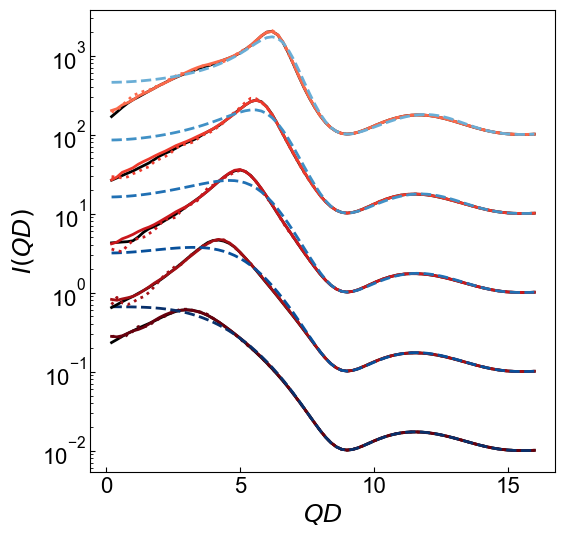

In [33]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    SQ_exp_GT = dict_eta['SQ_exp_GT_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)*10**i
    IQ_exp_NN = IQ_th(SQ_NN,fp_GT)*10**i
    IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)*10**i
    IQ_MD = IQ_exp(SQ_MD,fp_GT)*10**i

    ax.plot(q,IQ_exp_GT,
            '-k', lw=2, label='ground truth')
    ax.plot(q,IQ_MD,
            ':', lw=2, label='NN', color=c_NN)
    ax.plot(q,IQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,IQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.set_yscale('log')

plt.show()

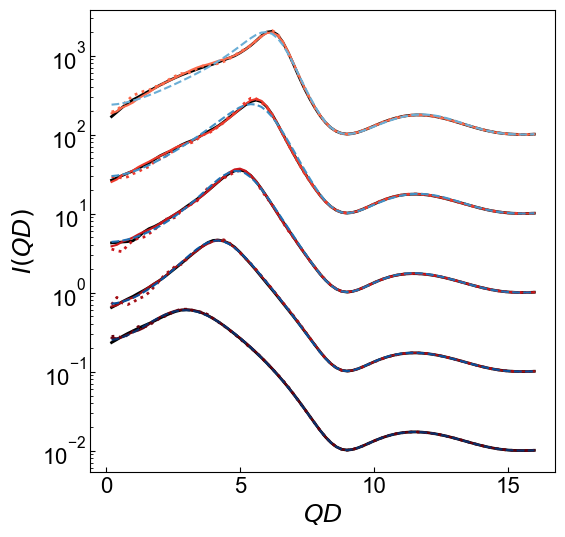

In [34]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
            label='RMSA', color=c_RMSA)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

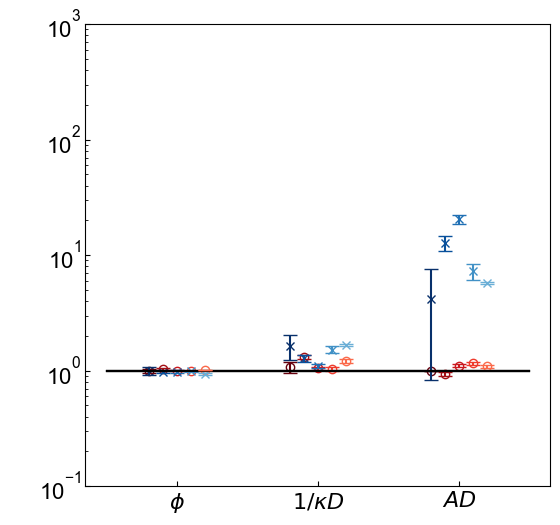

In [35]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)

for i in range(len(parameters_list)):
    ax = plt.subplot(1, 1, 1)
    
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_eta['fp_err_NN_list'][i]
    fp_err_RMSA = dict_eta['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
#     index = np.r_[index_free,6,7,8]
    x_shift = (i/len(parameters_list) - (len(parameters_list)-1)/2/len(parameters_list))/2
    index = [0,1,2]
    ax.plot(np.arange(len(index))+x_shift,fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
            label='NN', color=c_NN)
    ax.plot(np.arange(len(index))+x_shift,fp_opt_RMSA[index]/fp_GT[index],'x',
            label='RMSA', color=c_RMSA)
    ax.plot([-0.5,len(index)-0.5],[1,1],'-k')
    
    index_err = [0,1,2]
    ax.errorbar(np.arange(len(index_err))+x_shift,fp_opt_NN[index_err]/fp_GT[index_err], 
                abs(fp_err_NN[index_err]/fp_GT[index_err]),
           fmt='none',color=c_NN,capsize=5.0)
    ax.errorbar(np.arange(len(index_err))+x_shift,fp_opt_RMSA[index_err]/fp_GT[index_err], 
                abs(fp_err_RMSA[index_err]/fp_GT[index_err]),
           fmt='none',color=c_RMSA,capsize=5.0)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)
    ax.set_ylim([1e-1,1e3])
    
    tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                   r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']
    ax.set_xticks(np.arange(len(index)))
    ax.set_xticklabels([tick_labels[it] for it in index])

#     ax.set_xlabel('parameters',fontsize=18)
    ax.set_ylabel(' ',fontsize=18)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

In [36]:
fp_GT[0]

0.405

## kappa

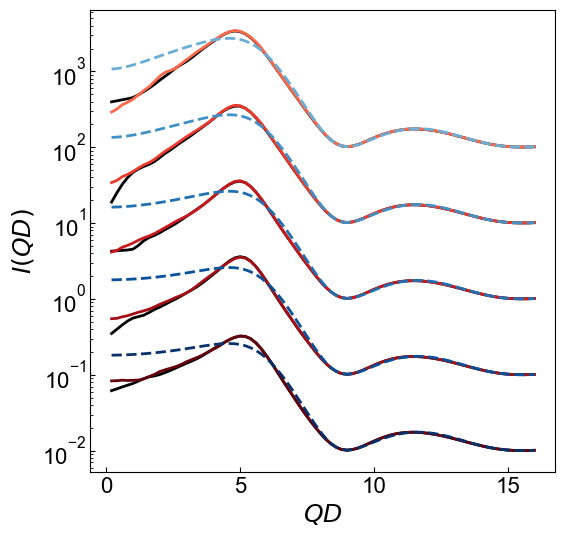

In [37]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)*10**i
    IQ_exp_NN = IQ_th(SQ_NN,fp_GT)*10**i
    IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)*10**i

    ax.plot(q,IQ_exp_GT,
            '-k', lw=2, label='ground truth')
    ax.plot(q,IQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,IQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)


ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.set_yscale('log')

plt.show()

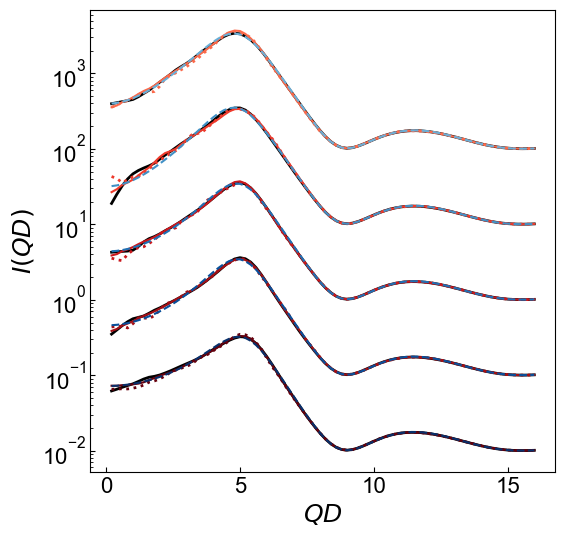

In [38]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
            label='RMSA', color=c_RMSA)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

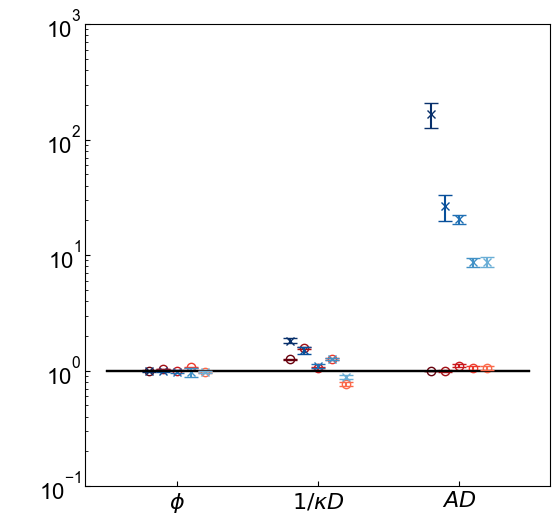

In [39]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)

for i in range(len(parameters_list)):
    ax = plt.subplot(1, 1, 1)
    
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
        
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
#     index = np.r_[index_free,6,7,8]
    x_shift = (i/len(parameters_list) - (len(parameters_list)-1)/2/len(parameters_list))/2
    index = [0,1,2]
    ax.plot(np.arange(len(index))+x_shift,fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
            label='NN', color=c_NN)
    ax.plot(np.arange(len(index))+x_shift,fp_opt_RMSA[index]/fp_GT[index],'x',
            label='RMSA', color=c_RMSA)
    ax.plot([-0.5,len(index)-0.5],[1,1],'-k')
    
    index_err = [0,1,2]
    ax.errorbar(np.arange(len(index_err))+x_shift,fp_opt_NN[index_err]/fp_GT[index_err], 
                abs(fp_err_NN[index_err]/fp_GT[index_err]),
           fmt='none',color=c_NN,capsize=5.0)
    ax.errorbar(np.arange(len(index_err))+x_shift,fp_opt_RMSA[index_err]/fp_GT[index_err], 
                abs(fp_err_RMSA[index_err]/fp_GT[index_err]),
           fmt='none',color=c_RMSA,capsize=5.0)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)
    ax.set_ylim([1e-1,1e3])
    
    tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                   r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']
    ax.set_xticks(np.arange(len(index)))
    ax.set_xticklabels([tick_labels[it] for it in index])

#     ax.set_xlabel('parameters',fontsize=18)
    ax.set_ylabel(' ',fontsize=18)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

## A

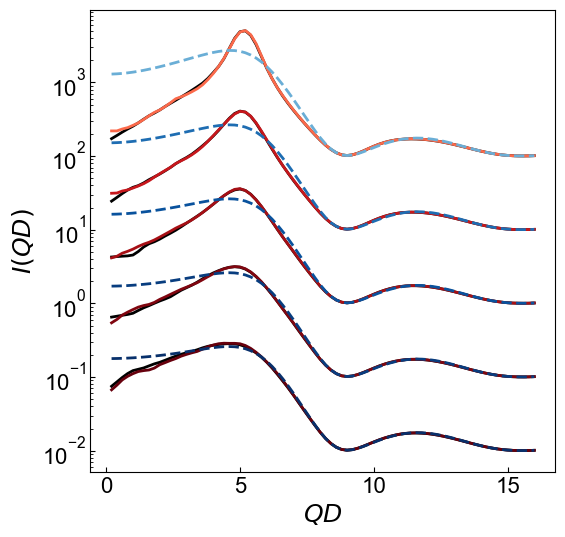

In [40]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    SQ_exp_GT = dict_A['SQ_exp_GT_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)*10**i
    IQ_exp_NN = IQ_th(SQ_NN,fp_GT)*10**i
    IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)*10**i

    ax.plot(q,IQ_exp_GT,
            '-k', lw=2, label='ground truth')
    ax.plot(q,IQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,IQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.set_yscale('log')

plt.show()

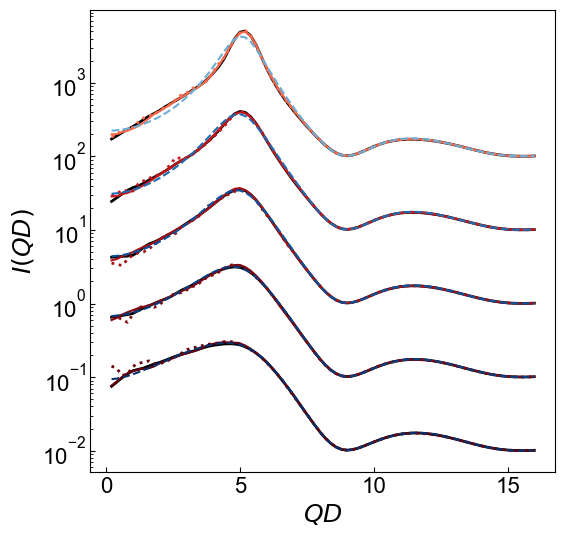

In [41]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
            label='RMSA', color=c_RMSA)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

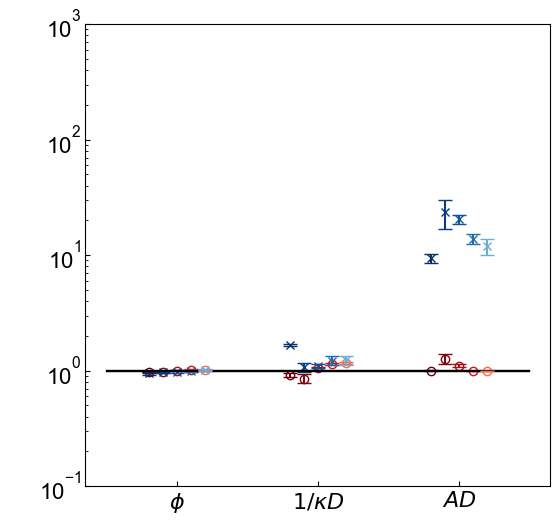

In [42]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):

    fp_GT = dict_A['fp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_A['fp_err_NN_list'][i]
    fp_err_RMSA = dict_A['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
#     index = np.r_[index_free,6,7,8]
    x_shift = (i/len(parameters_list) - (len(parameters_list)-1)/2/len(parameters_list))/2
    index = [0,1,2]
    ax.plot(np.arange(len(index))+x_shift,fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
            label='NN', color=c_NN)
    ax.plot(np.arange(len(index))+x_shift,fp_opt_RMSA[index]/fp_GT[index],'x',
            label='RMSA', color=c_RMSA)
    ax.plot([-0.5,len(index)-0.5],[1,1],'-k')
    
    index_err = [0,1,2]
    ax.errorbar(np.arange(len(index_err))+x_shift,fp_opt_NN[index_err]/fp_GT[index_err], 
                abs(fp_err_NN[index_err]/fp_GT[index_err]),
           fmt='none',color=c_NN,capsize=5.0)
    ax.errorbar(np.arange(len(index_err))+x_shift,fp_opt_RMSA[index_err]/fp_GT[index_err], 
                abs(fp_err_RMSA[index_err]/fp_GT[index_err]),
           fmt='none',color=c_RMSA,capsize=5.0)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)
    ax.set_ylim([1e-1,1e3])
    
    tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                   r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']
    ax.set_xticks(np.arange(len(index)))
    ax.set_xticklabels([tick_labels[it] for it in index])

#     ax.set_xlabel('parameters',fontsize=18)
    ax.set_ylabel(' ',fontsize=18)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

## Table

In [43]:
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
def print_table(dict_patameter):
    with open('table.txt', 'a') as f:
        for i in range(len(parameters_list)):

            fp_GT = dict_patameter['fp_GT_list'][i]
            fp_opt_NN = dict_patameter['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_patameter['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_patameter['fp_err_NN_list'][i]
            fp_err_RMSA = dict_patameter['fp_err_RMSA_list'][i]

        #     #relative error
        #     fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
        #     fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT

            index_print = [0,1,2]

            string_GT = '{:0.3f},{:0.3f},{:0.3f},'.format(*fp_GT)
            string_NN = ''
            for j in index_print:
                string_NN += '{:0.3f}pm{:0.3f},'.format(fp_opt_NN[j],fp_err_NN[j])
            string_RMSA = ''
            for j in index_print:
                string_RMSA += '{:0.3f}pm{:0.3f},'.format(fp_opt_RMSA[j],fp_err_RMSA[j])

            string_row = string_GT+string_NN+string_RMSA+'\n'
            print(string_row)
            f.write(string_row)
            
for i in dict_patameter_list:
    print_table(i)

0.045,0.300,6.000,0.045pm0.002,0.321pm0.036,6.001pm0.013,0.045pm0.003,0.488pm0.119,25.105pm20.171,

0.135,0.300,6.000,0.139pm0.003,0.395pm0.015,5.593pm0.235,0.131pm0.004,0.383pm0.023,76.293pm11.183,

0.225,0.300,6.000,0.224pm0.002,0.314pm0.012,6.625pm0.169,0.221pm0.005,0.329pm0.011,122.153pm10.618,

0.315,0.300,6.000,0.313pm0.002,0.312pm0.013,6.969pm0.195,0.312pm0.003,0.457pm0.031,43.335pm6.900,

0.405,0.300,6.000,0.409pm0.003,0.366pm0.014,6.550pm0.185,0.380pm0.006,0.500pm0.010,34.649pm0.673,

0.225,0.100,6.000,0.225pm0.002,0.126pm0.001,6.000pm0.010,0.222pm0.003,0.182pm0.008,999.822pm246.164,

0.225,0.200,6.000,0.232pm0.002,0.316pm0.007,5.985pm0.118,0.223pm0.004,0.300pm0.020,160.027pm40.790,

0.225,0.300,6.000,0.224pm0.002,0.314pm0.012,6.625pm0.169,0.221pm0.005,0.329pm0.011,122.153pm10.618,

0.225,0.400,6.000,0.241pm0.002,0.500pm0.010,6.314pm0.241,0.217pm0.020,0.500pm0.010,52.180pm4.909,

0.225,0.500,6.000,0.219pm0.003,0.383pm0.014,6.322pm0.196,0.219pm0.004,0.443pm0.019,52.352pm5.094,


In [44]:
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
def print_table_MD(dict_patameter):
    with open('table_MD.txt', 'a') as f:
        for i in range(len(parameters_list)):

            fp_GT = dict_patameter['fp_GT_list'][i]
            fp_opt_NN = dict_patameter['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_patameter['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_patameter['fp_err_NN_list'][i]
            fp_err_RMSA = dict_patameter['fp_err_RMSA_list'][i]

        #     #relative error
        #     fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
        #     fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT

            index_print = [0,1,2]

            string_NN = ''
            for j in index_print:
                string_NN += '{:0.3f},'.format(fp_opt_NN[j])
            string_row = string_NN+'\n'
            print(string_row)
            f.write(string_row)
            
for i in dict_patameter_list:
    print_table_MD(i)

0.045,0.321,6.001,

0.139,0.395,5.593,

0.224,0.314,6.625,

0.313,0.312,6.969,

0.409,0.366,6.550,

0.225,0.126,6.000,

0.232,0.316,5.985,

0.224,0.314,6.625,

0.241,0.500,6.314,

0.219,0.383,6.322,

0.217,0.276,1.000,

0.218,0.256,3.775,

0.224,0.314,6.625,

0.227,0.344,10.001,

0.227,0.352,20.000,



In [45]:
# save fitting results
from scipy.io import savemat
savemat('fp_eta_SQ.mat',dict_eta)
savemat('fp_kappa_SQ.mat',dict_kappa)
savemat('fp_A_SQ.mat',dict_A)